## Evaluate Robot Motions with Original Transfer Functions

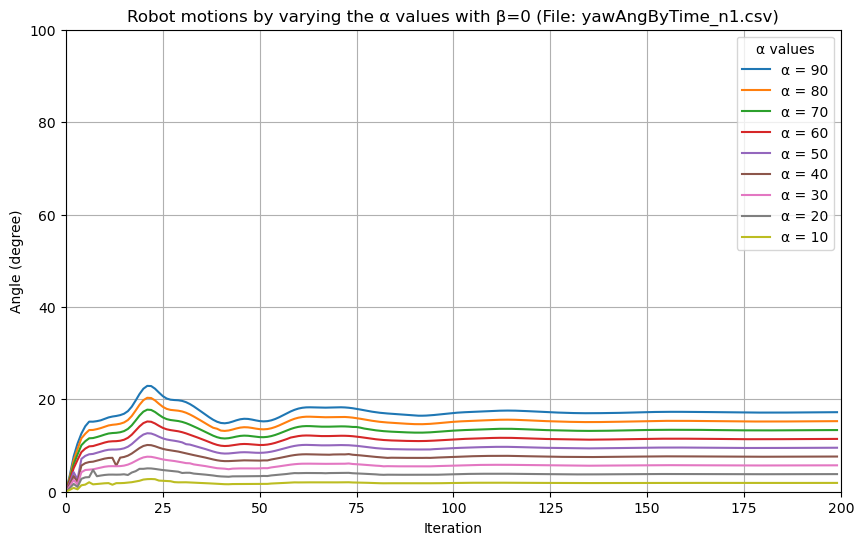

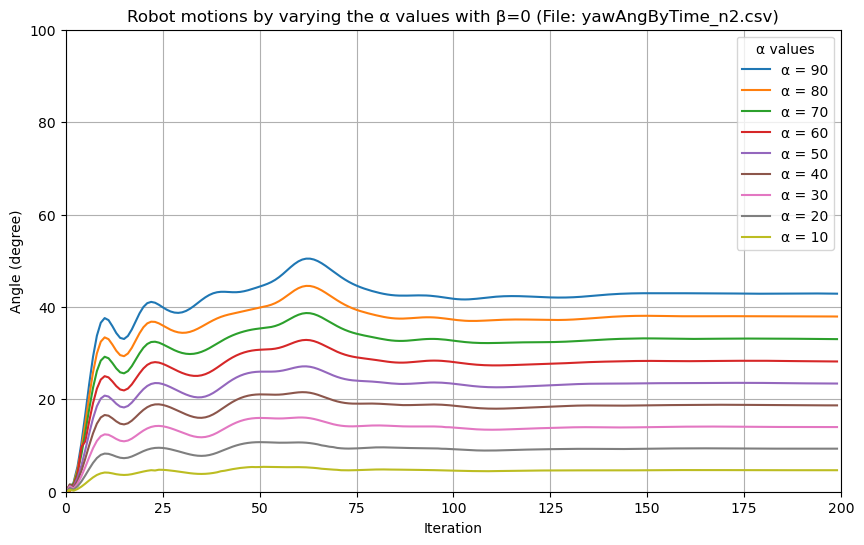

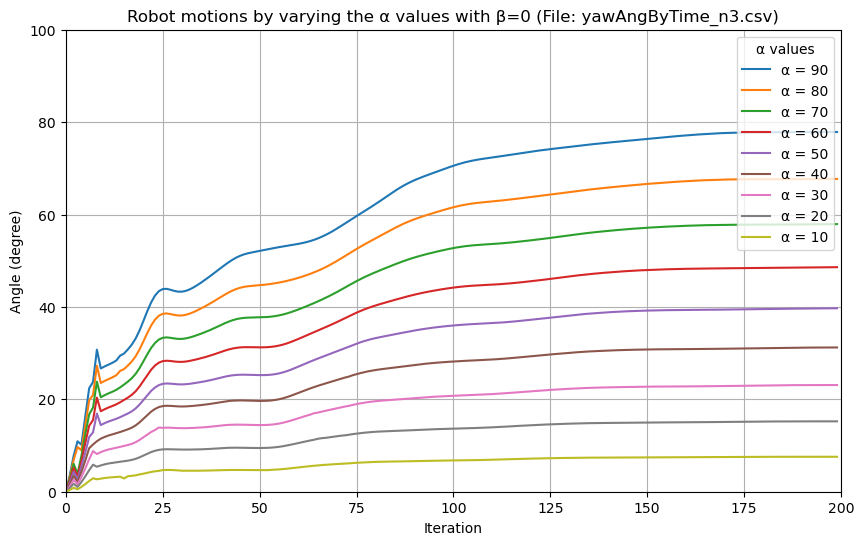

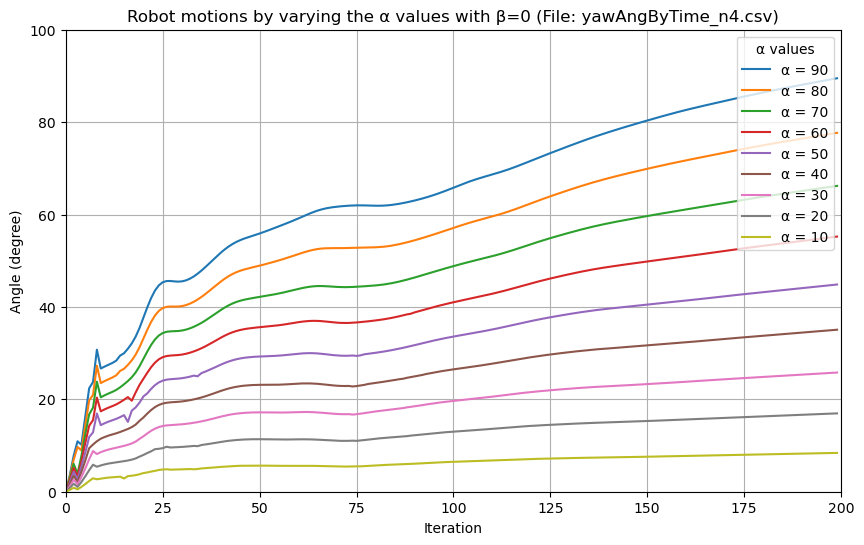

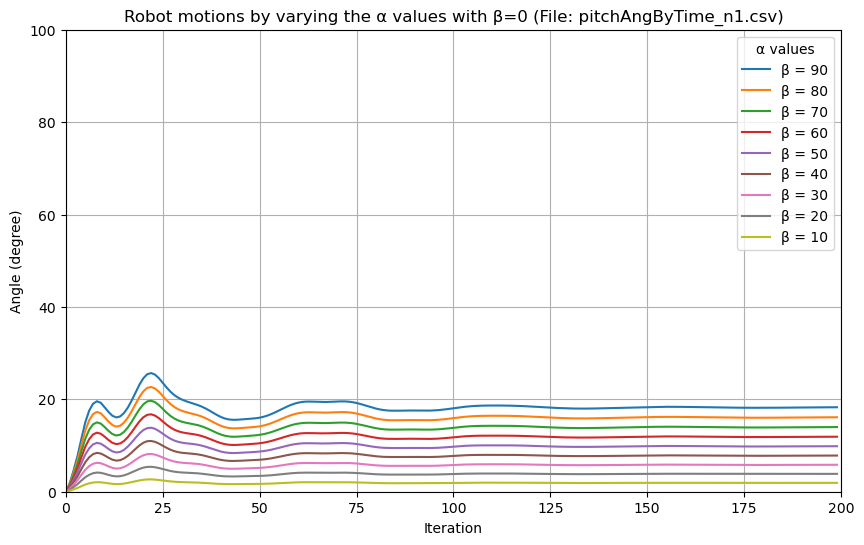

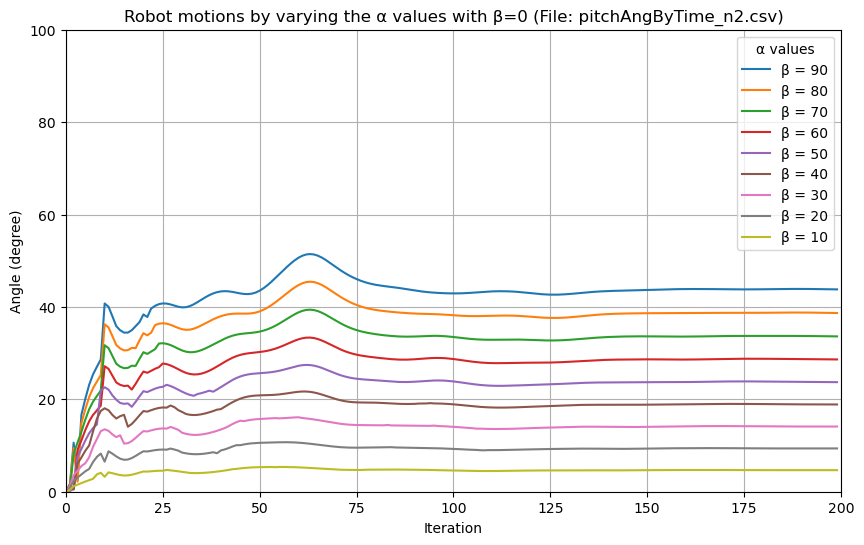

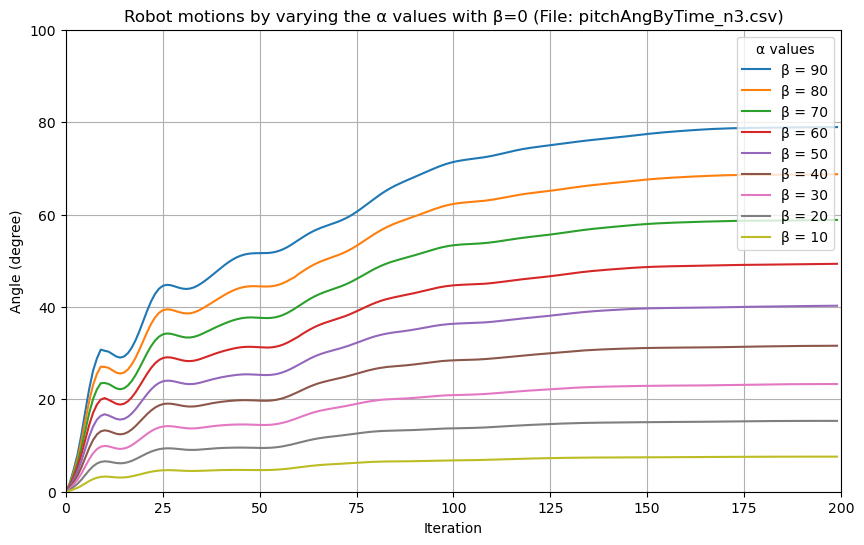

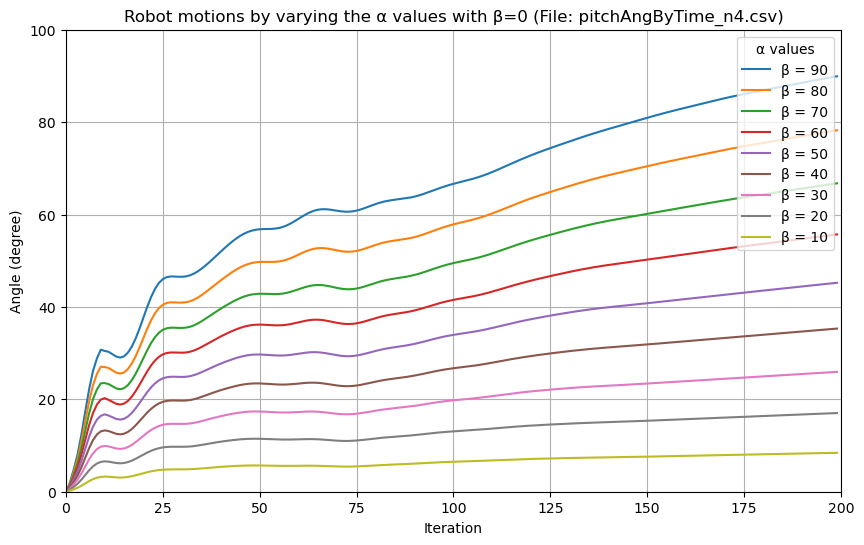

In [13]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# List of filenames
filenames = [
    "yawAngByTime_n1.csv",
    "yawAngByTime_n2.csv",
    "yawAngByTime_n3.csv",
    "yawAngByTime_n4.csv",
    "pitchAngByTime_n1.csv",
    "pitchAngByTime_n2.csv",
    "pitchAngByTime_n3.csv",
    "pitchAngByTime_n4.csv"
]

# Directory where the files are stored
directory = "data/"
output = "result/"

# Iterate through each file
for filename in filenames:
    # Import dataset
    dataset_df = pd.read_csv(directory + filename)
    
    # Extract the time data (assuming time is the index)
    iteration = dataset_df.index

    # Plotting the data
    plt.figure(figsize=(10, 6))

    # Iterate through each column and plot
    for column in dataset_df.columns[::-1]:
        plt.plot(iteration, dataset_df[column], label=column)

    # Adding labels and title
    plt.xlabel('Iteration')
    plt.ylabel('Angle (degree)')
    plt.grid(True)
    plt.xlim(0, 200)
    plt.ylim(0, 100)
    plt.title(f'Robot motions by varying the α values with β=0 (File: {filename})')
    plt.legend(title='α values', loc='upper right')

    # Save the plot
    plt.savefig(output + 'fig_' + filename.replace('.csv', '.png'), dpi=300)
    
    # Display the plot
    plt.show()


#### The results indicate that there are significant deviations using the original transfer functions. Now we can optimize them by machine learning methods. Firstly, let's start with data collection.

## Visualization of Training Dataset

### Training input

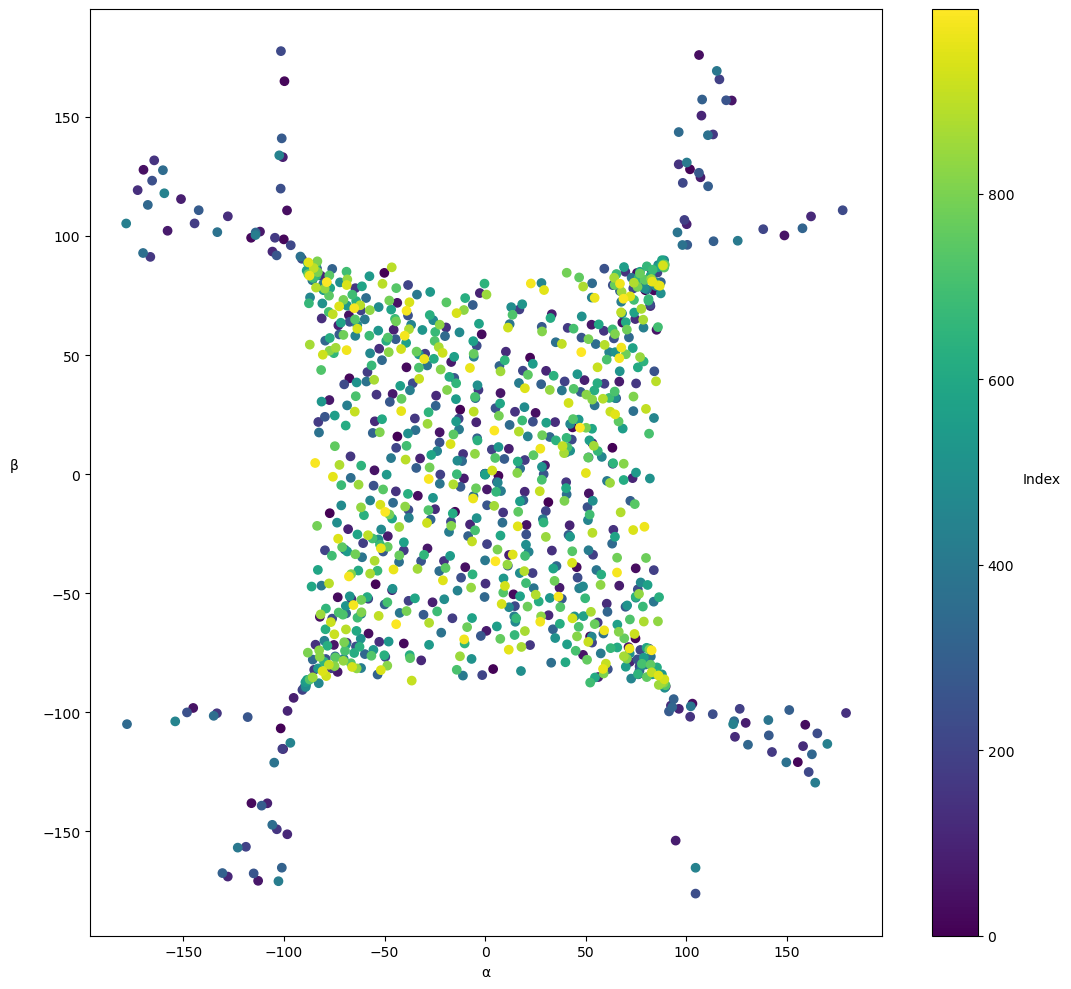

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = 'data/training.csv'  
df = pd.read_csv(file_path)

# Create a 2D plot with color gradient
fig, ax = plt.subplots(figsize=(11, 10))

# Plot the data with a color gradient based on the index
scatter = ax.scatter(df.iloc[:, 0], df.iloc[:, 1], c=df.index, cmap='viridis', marker='o')

# Set labels
ax.set_xlabel('α')
ax.set_ylabel('β', rotation=0, labelpad=20)
# Add a color bar for the index
cbar = plt.colorbar(scatter)
cbar.set_label('Index', rotation=0, labelpad=20)

plt.tight_layout()
plt.savefig(output + 'fig_' + "dataCollection_pitchYaw_2D.png", dpi=300)
plt.show()

### Training Output

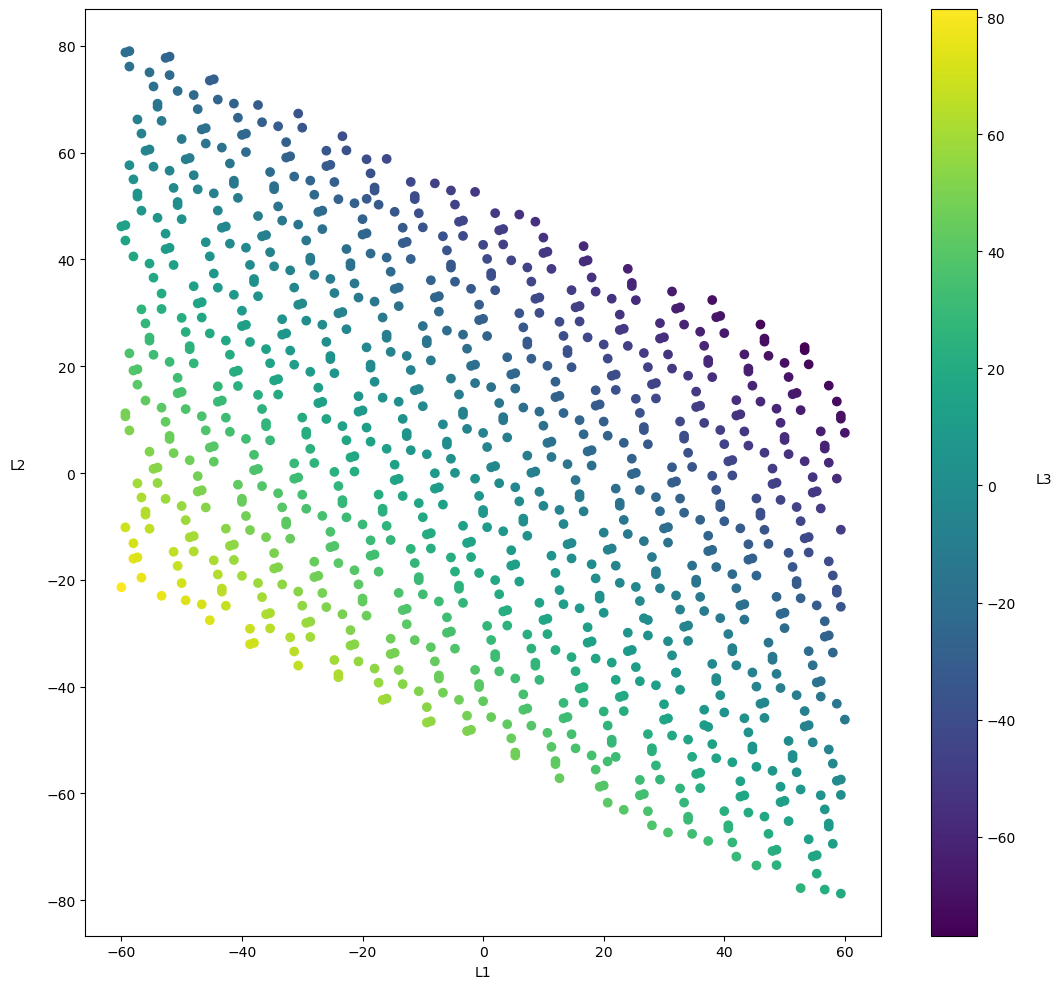

In [16]:
# Load the CSV file
file_path = 'data/training.csv'  
df = pd.read_csv(file_path)

# Create a 2D plot with color gradient
fig, ax = plt.subplots(figsize=(11, 10))

# Plot the data with a color gradient based on the L3
scatter = ax.scatter(df.iloc[:, 2], df.iloc[:, 3], c=df.iloc[:, 4], cmap='viridis', marker='o')

# Set labels
ax.set_xlabel('L1')
ax.set_ylabel('L2', rotation=0, labelpad=20)
# Add a color bar for the L3
cbar = plt.colorbar(scatter)
cbar.set_label('L3', rotation=0, labelpad=20)

plt.tight_layout()
plt.savefig(output + 'fig_' + "dataCollection_lengthVar_2D.png", dpi=300)
plt.show()

#### The training dataset is completed. As presented above, these data are multi-input (yaw and pitch angles) multi-output (length variations of each tendon). 
#### Next, let's build up the learning models. We will focus on four learning models: ensemble learning models (Random Forest, Gradient Boosting), regularization-based models (Ridge, Lasso Regression), kernel-based models (Support Vector Regressor, Gaussian Process Regressor), and neural network models (Bayesian Neural Network, Recurrent Neural Network). These models are suitable for multi-input multi-ouput (MIMO), non-linear data.

## Training Process

### Learning models setup

In [22]:
## Import libraries

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Input
import time

# Load the dataset
file_path = "data/training.csv"
data = pd.read_csv(file_path)

# Extract input and output columns
X = data[['α', 'β']]
y = data[['L1', 'L2', 'L3']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the input data for RNN
X_train_rnn = np.expand_dims(X_train, axis=1)
X_test_rnn = np.expand_dims(X_test, axis=1)

# Define a function to build a simple Bayesian Neural Network
def build_bnn(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(3)  # Three outputs for L1, L2, L3
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Define a function to build a simple RNN
def build_rnn(input_dim):
    model = Sequential([
        Input(shape=(1, input_dim)),
        SimpleRNN(64, activation='relu', return_sequences=False),
        Dense(64, activation='relu'),
        Dense(3)  # Three outputs for L1, L2, L3
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Initialize models
models = {
    "Random Forest": MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42)),
    "Gradient Boosting": MultiOutputRegressor(GradientBoostingRegressor(n_estimators=100, random_state=42)),
    "Ridge Regression": MultiOutputRegressor(Ridge(alpha=1.0)),
    "Lasso Regression": MultiOutputRegressor(Lasso(alpha=0.1)),
    "Support Vector Regressor": MultiOutputRegressor(SVR()),
    "Bayesian Neural Network": build_bnn(X_train.shape[1]),
    "Recurrent Neural Network": build_rnn(X_train.shape[1]),
    "Gaussian Process Regressor": MultiOutputRegressor(GaussianProcessRegressor())
}

results = []


### Train and evaluate each model

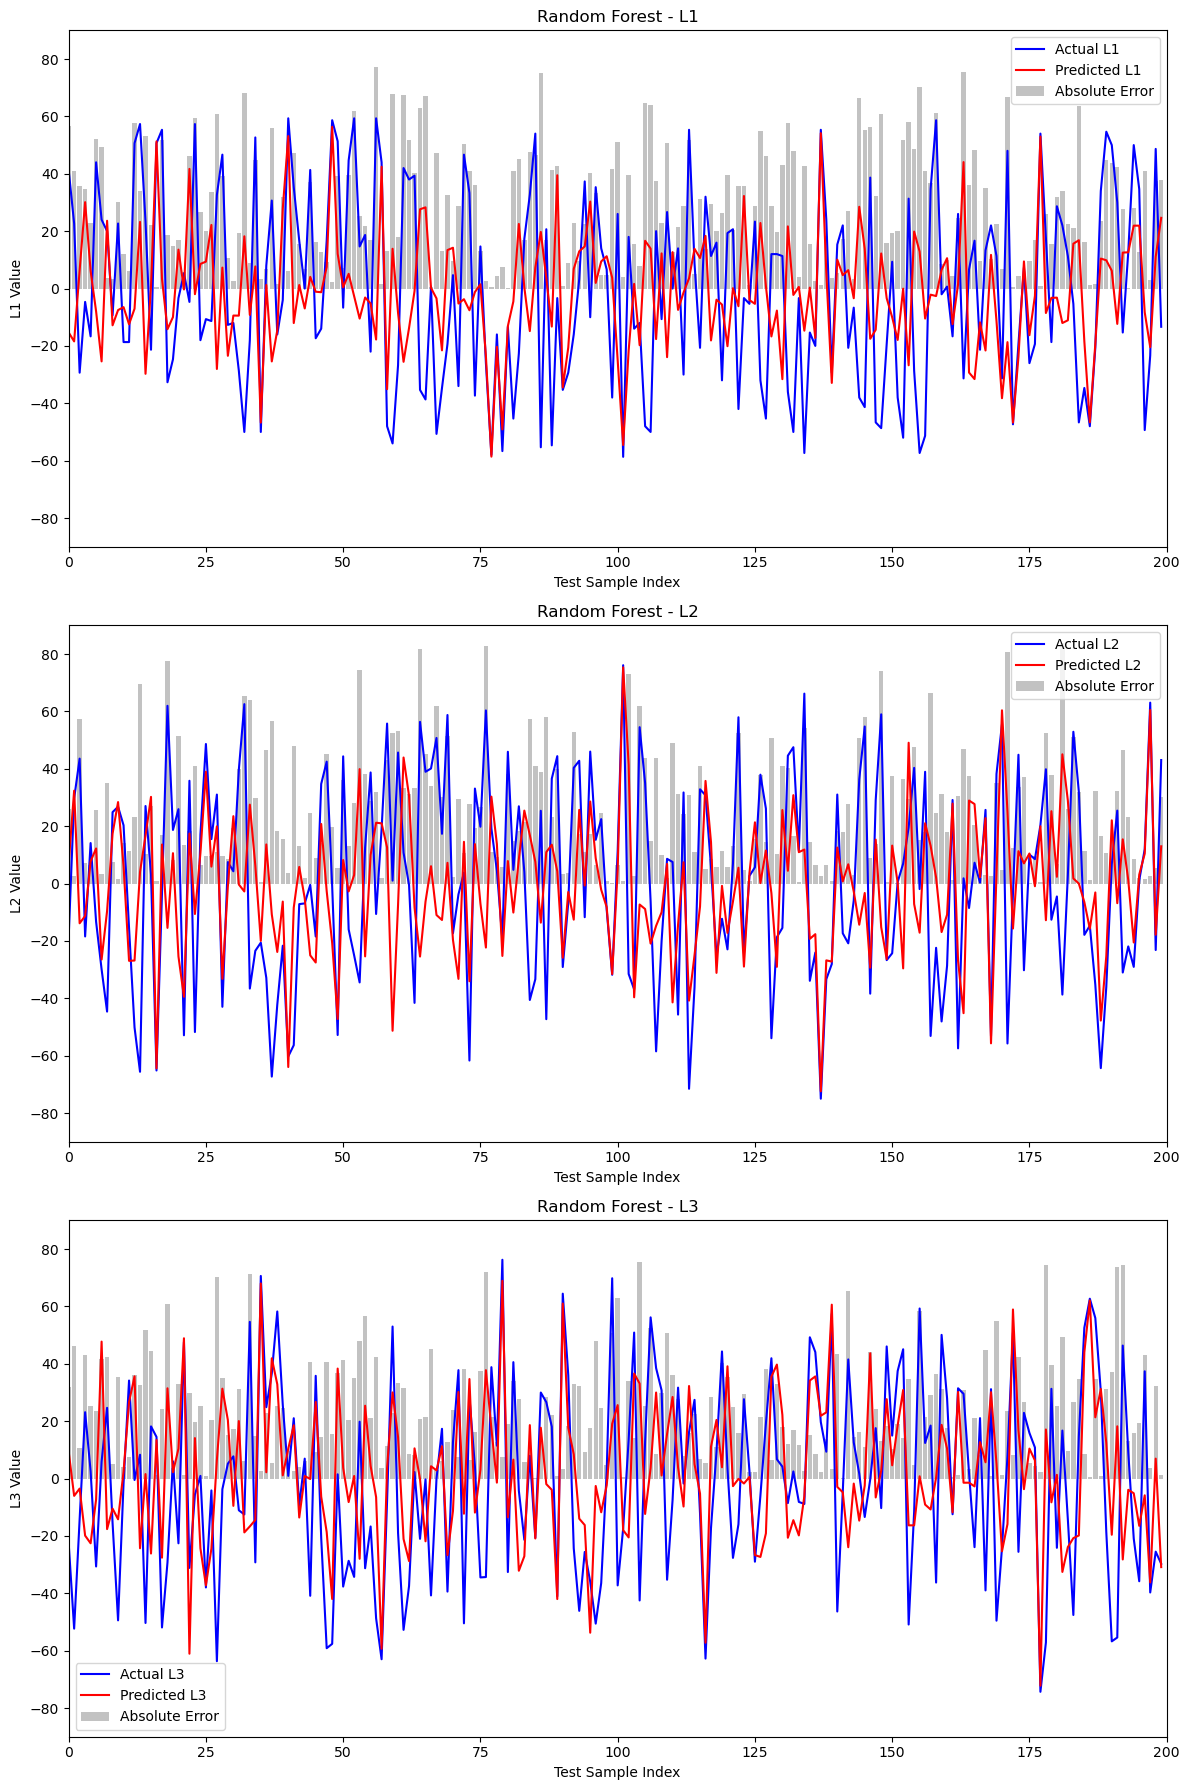

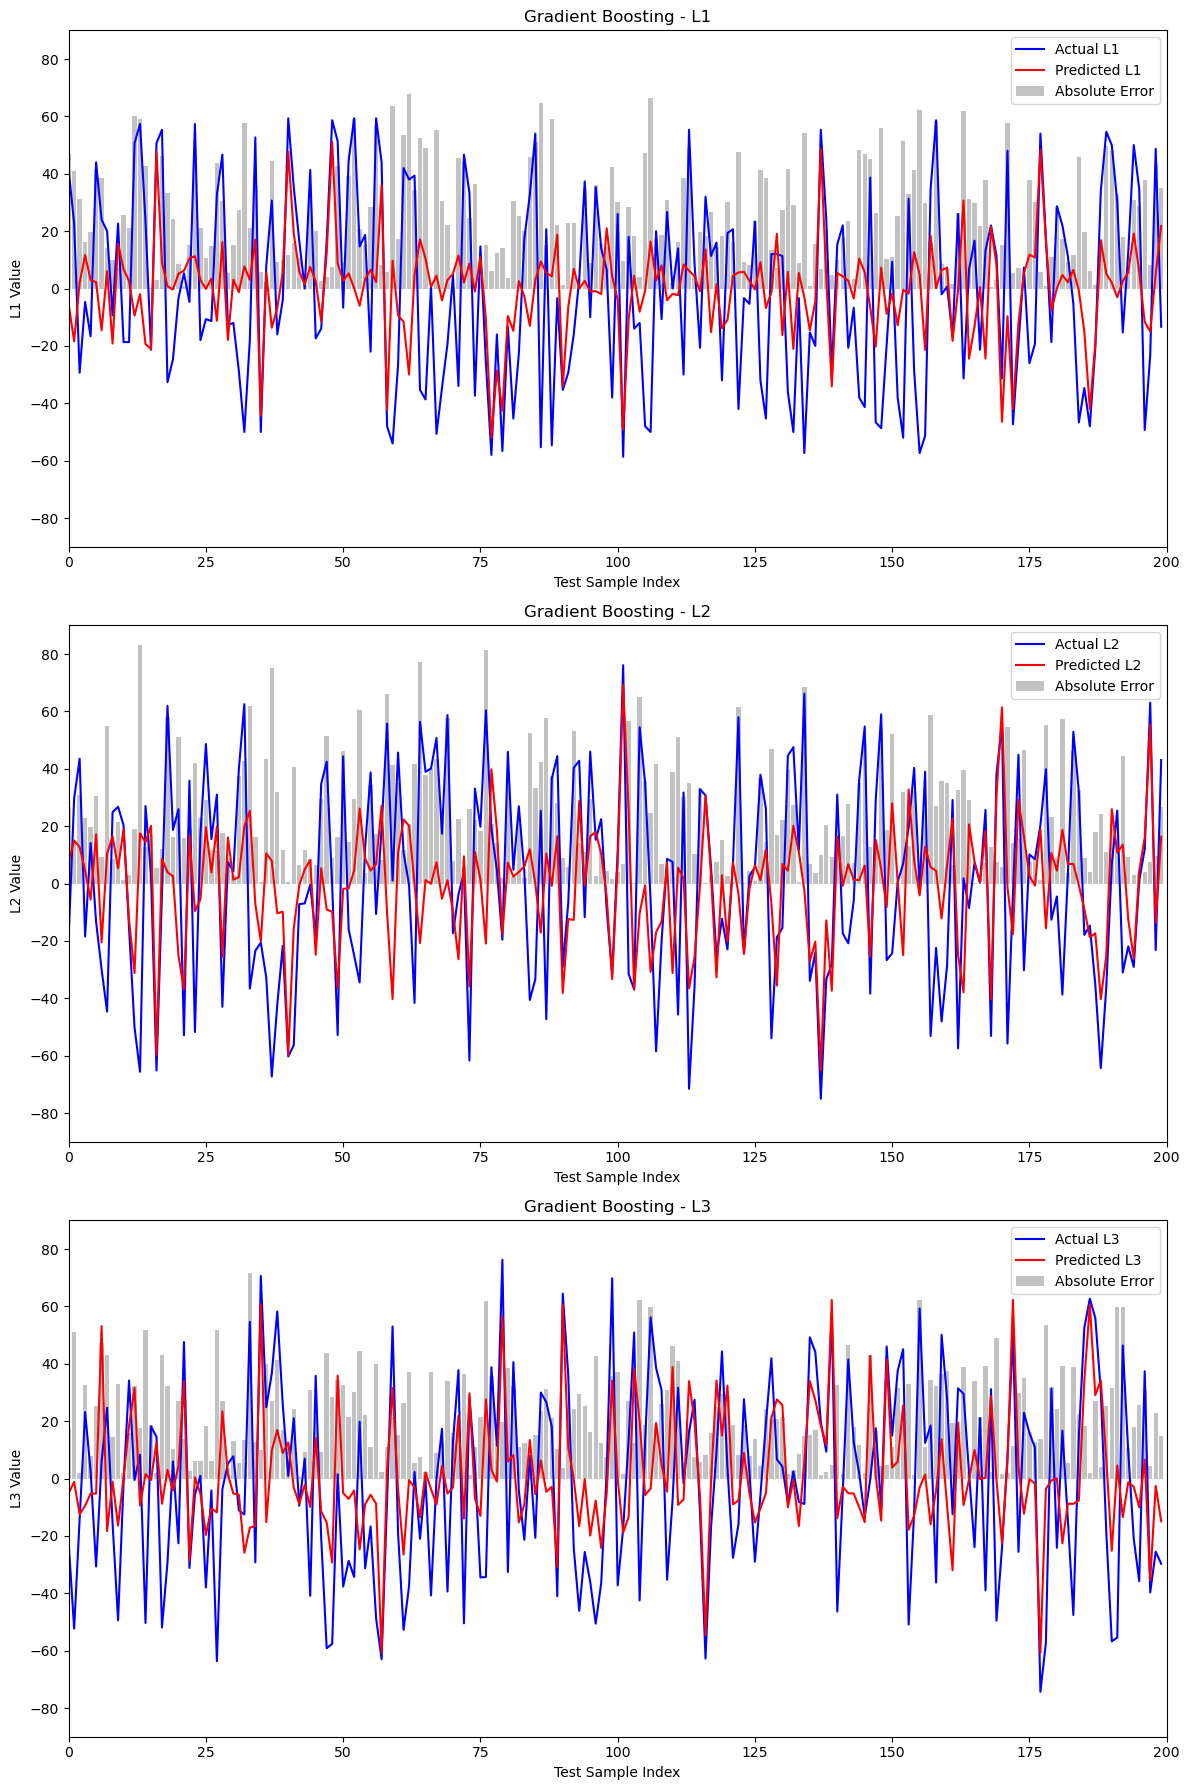

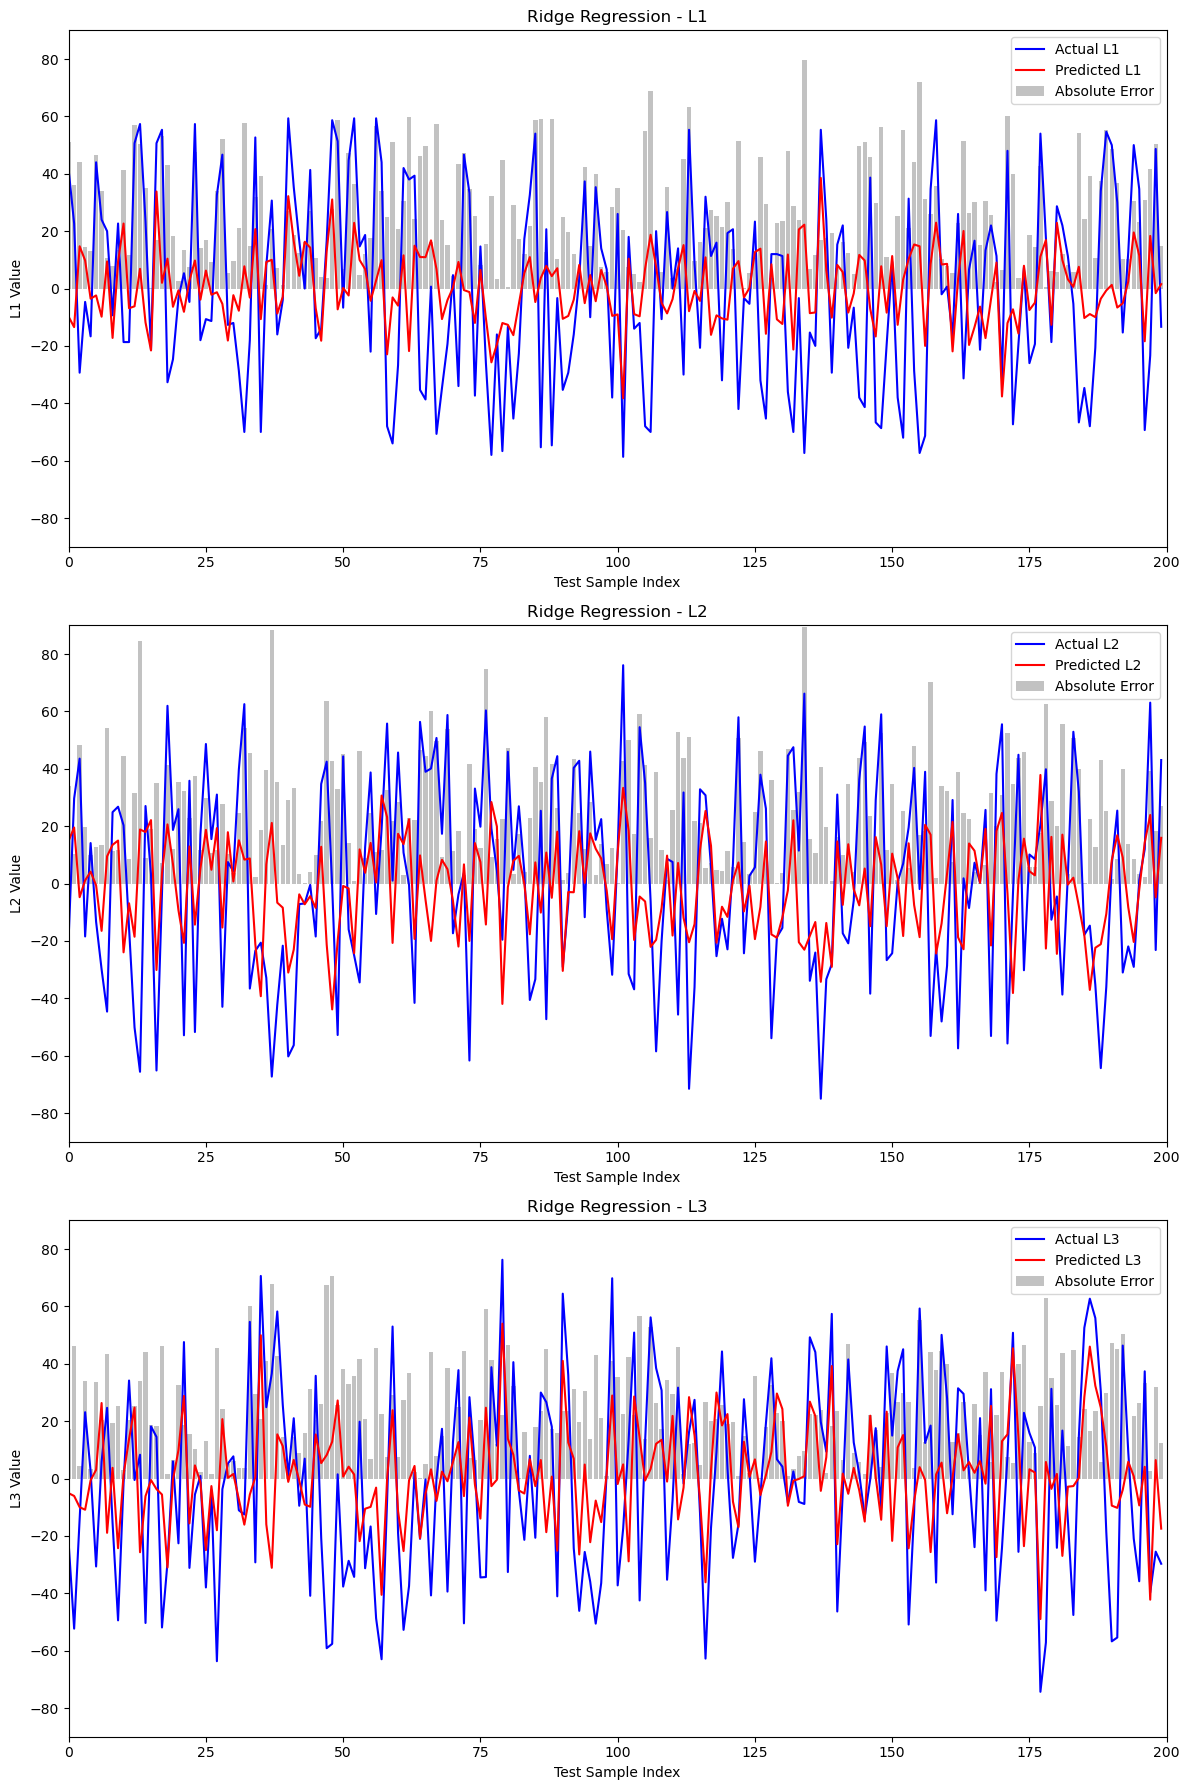

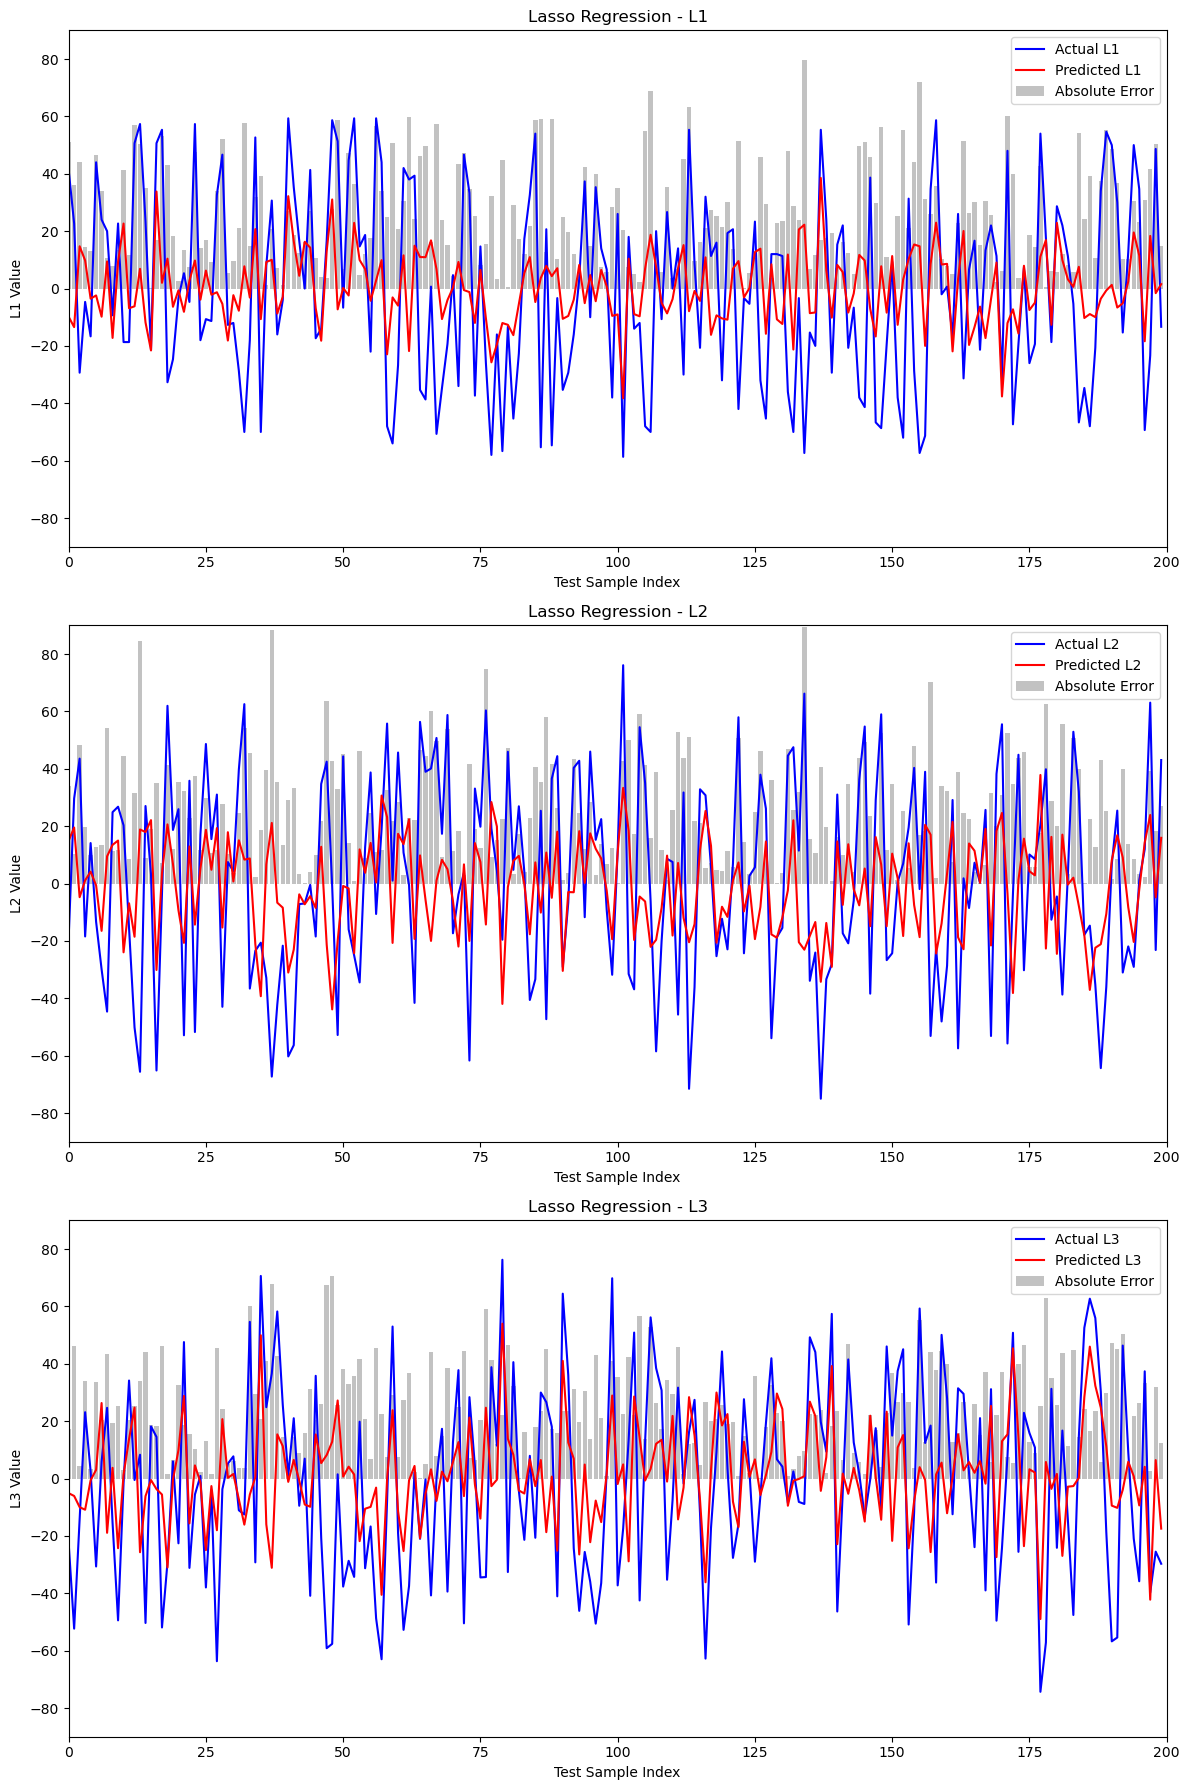

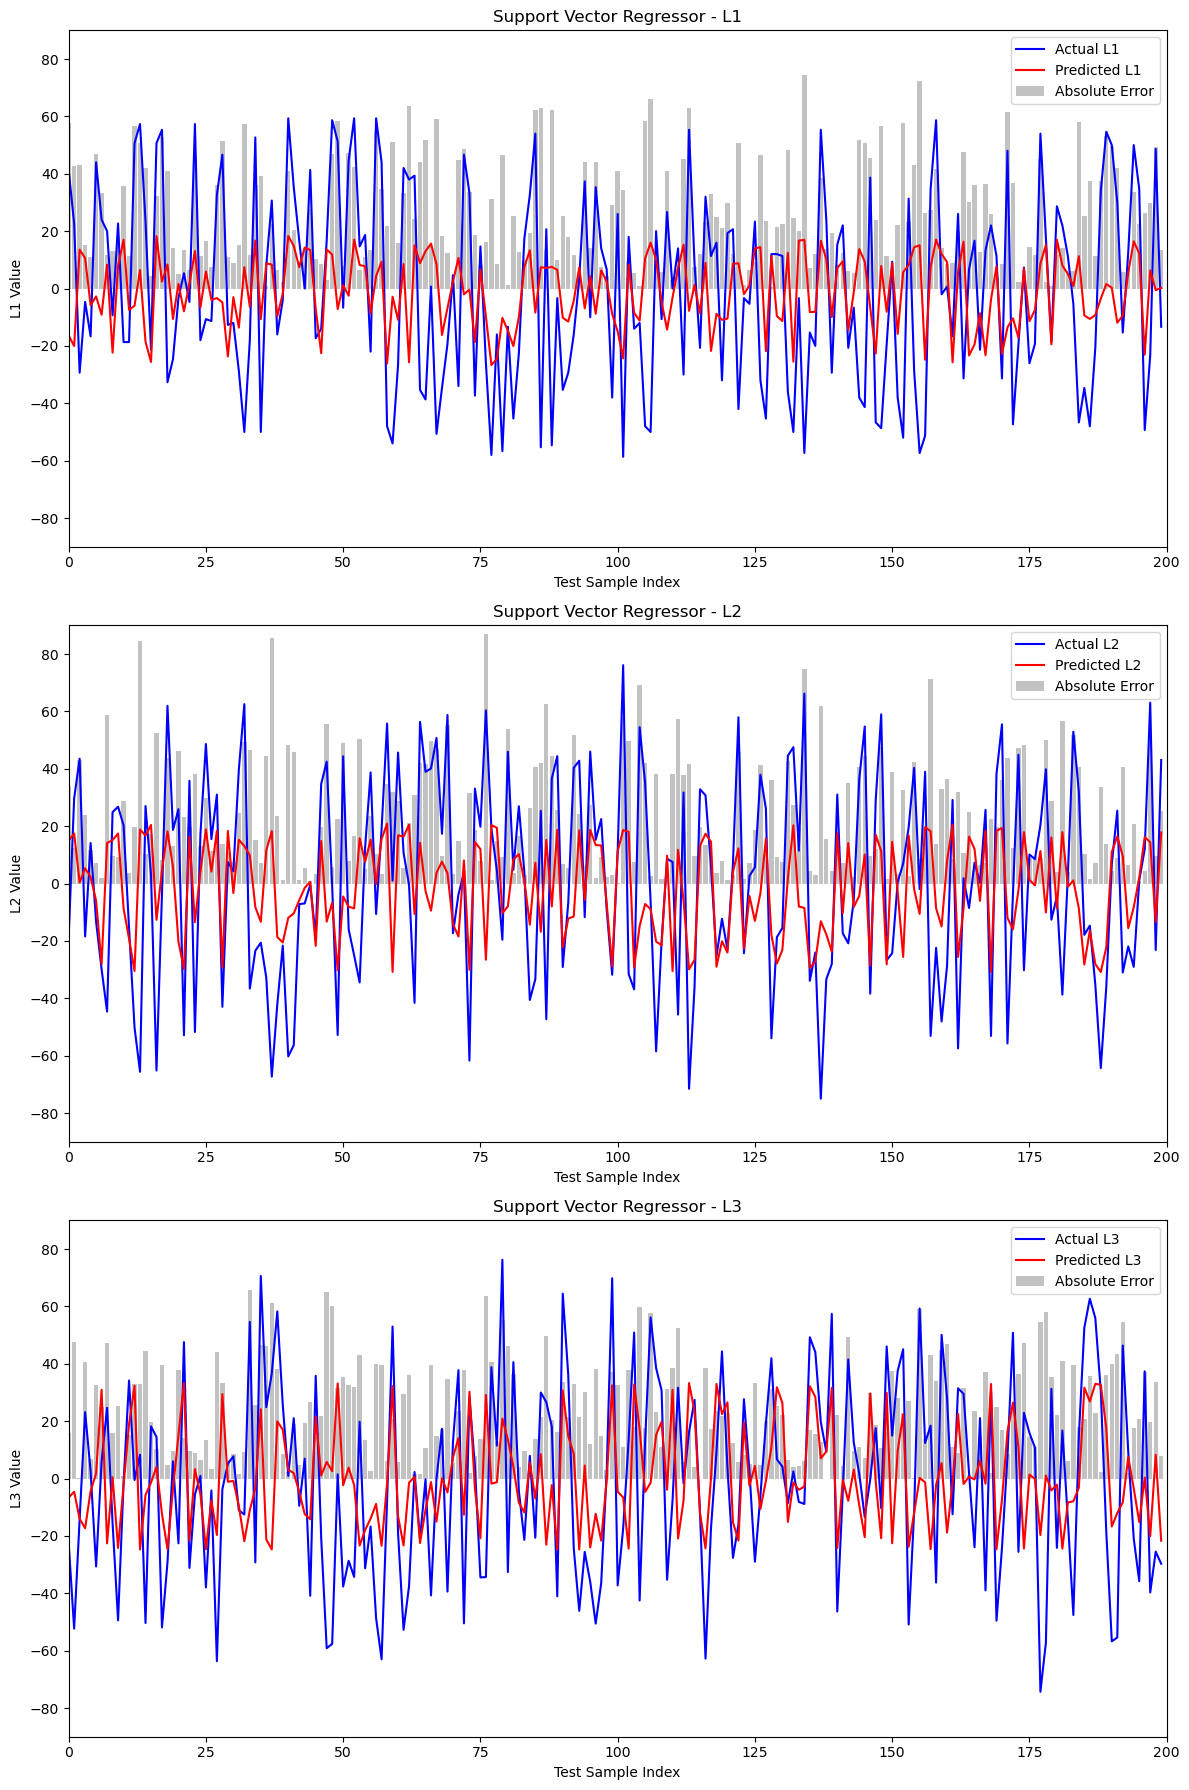

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


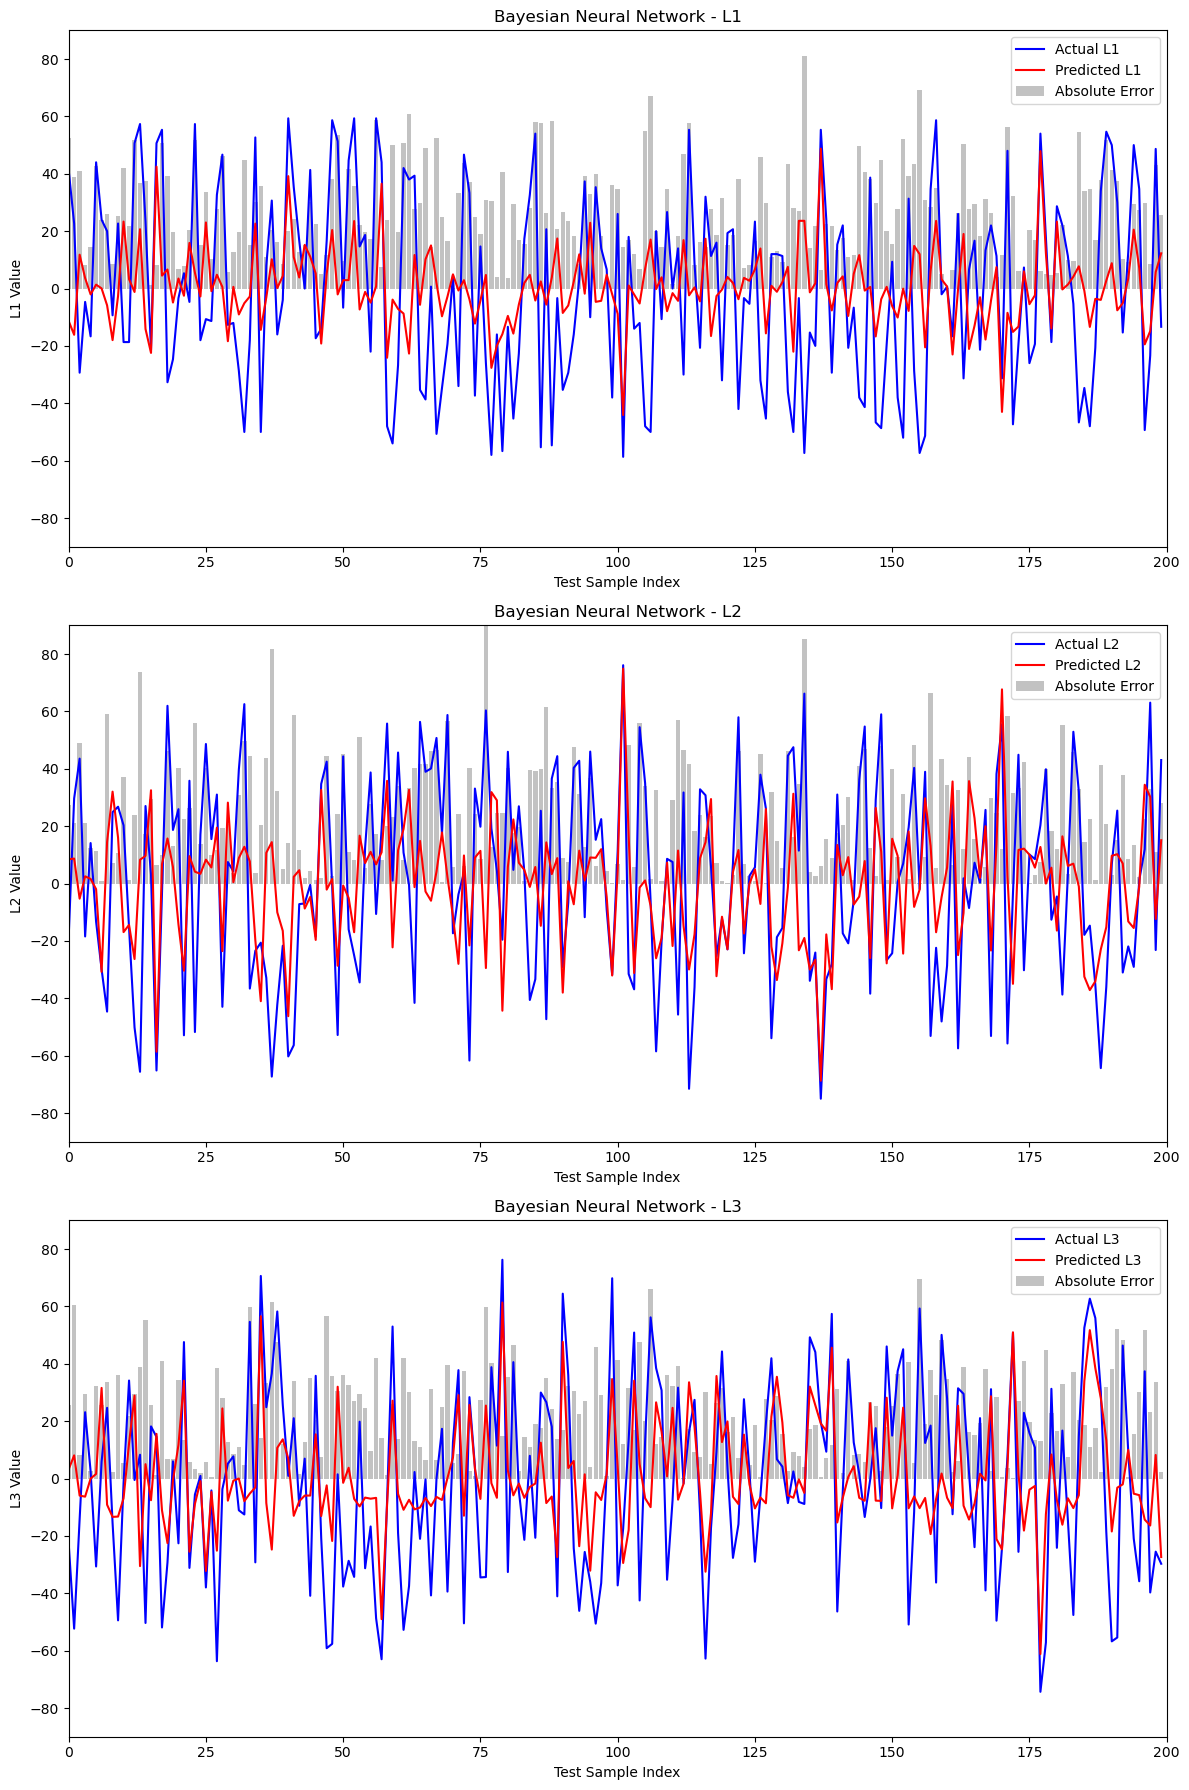

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


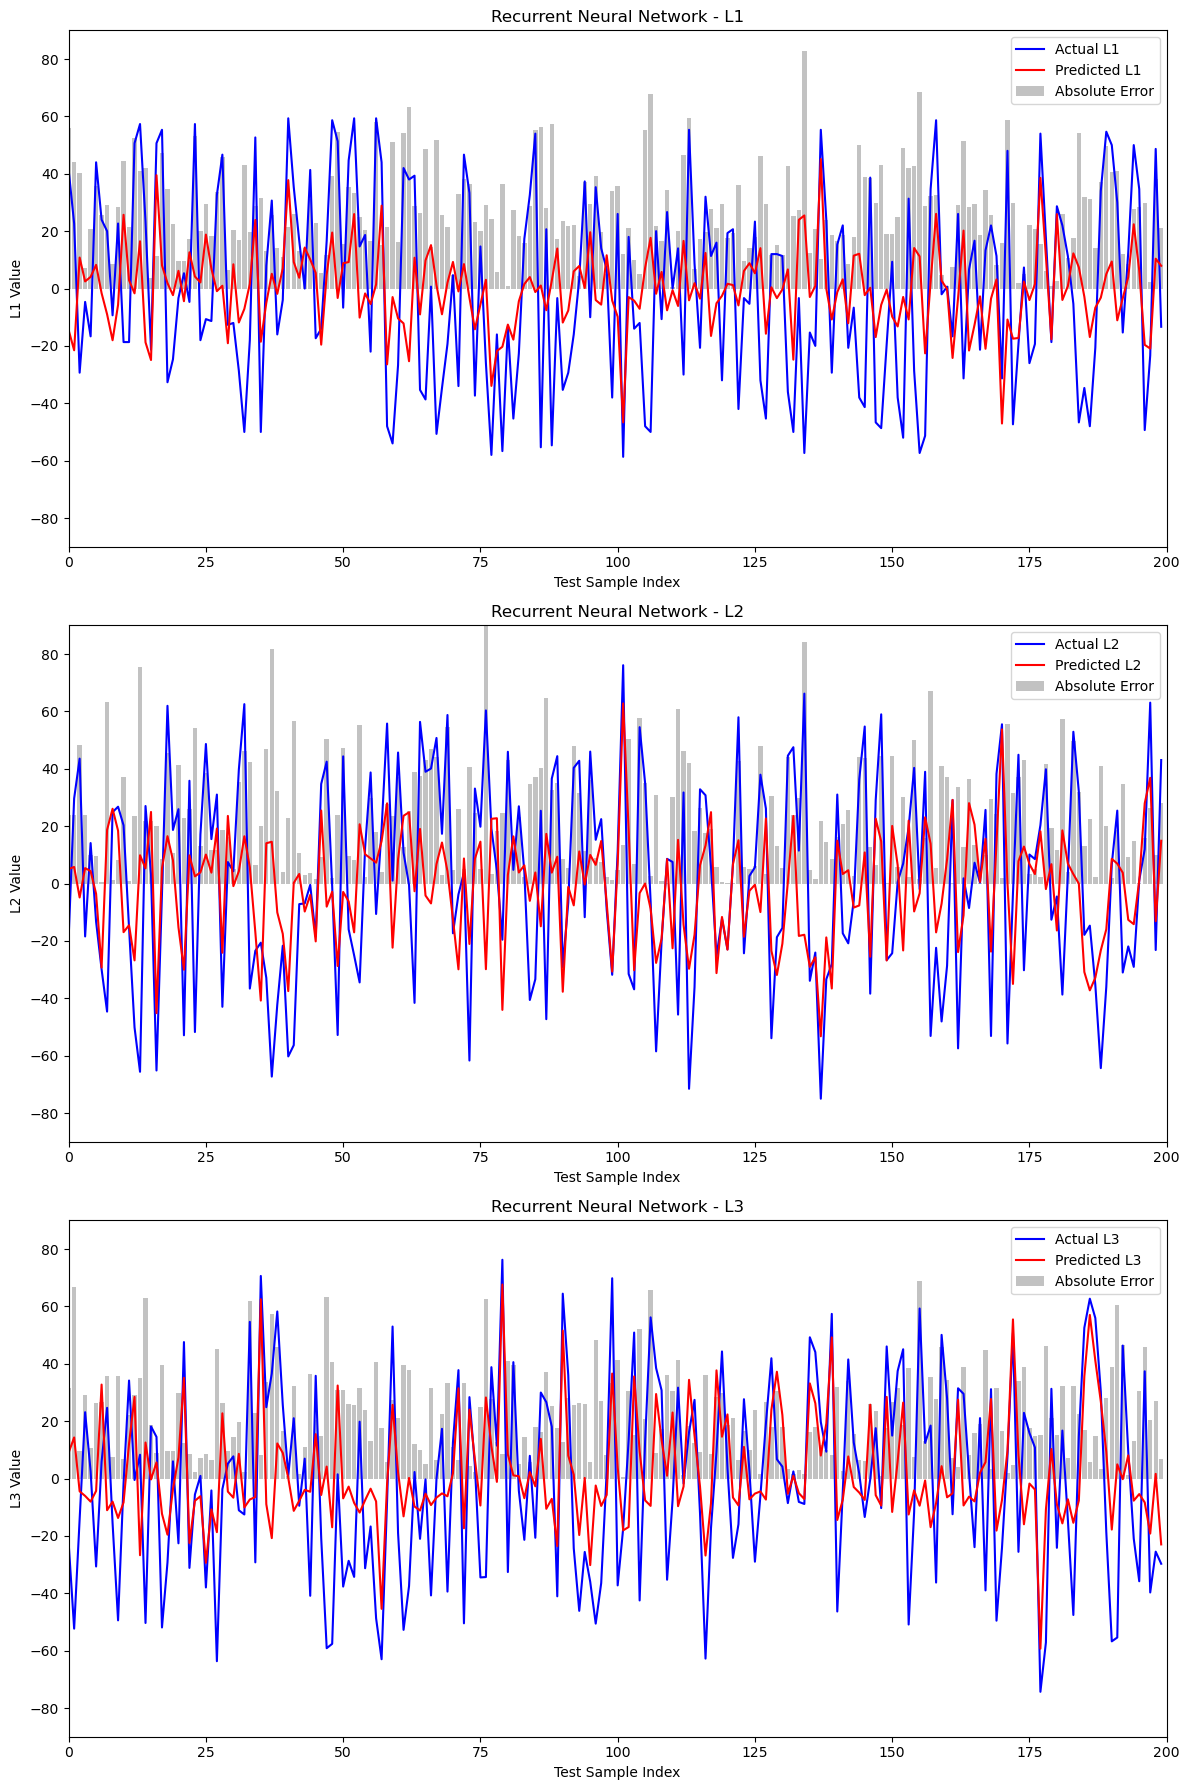

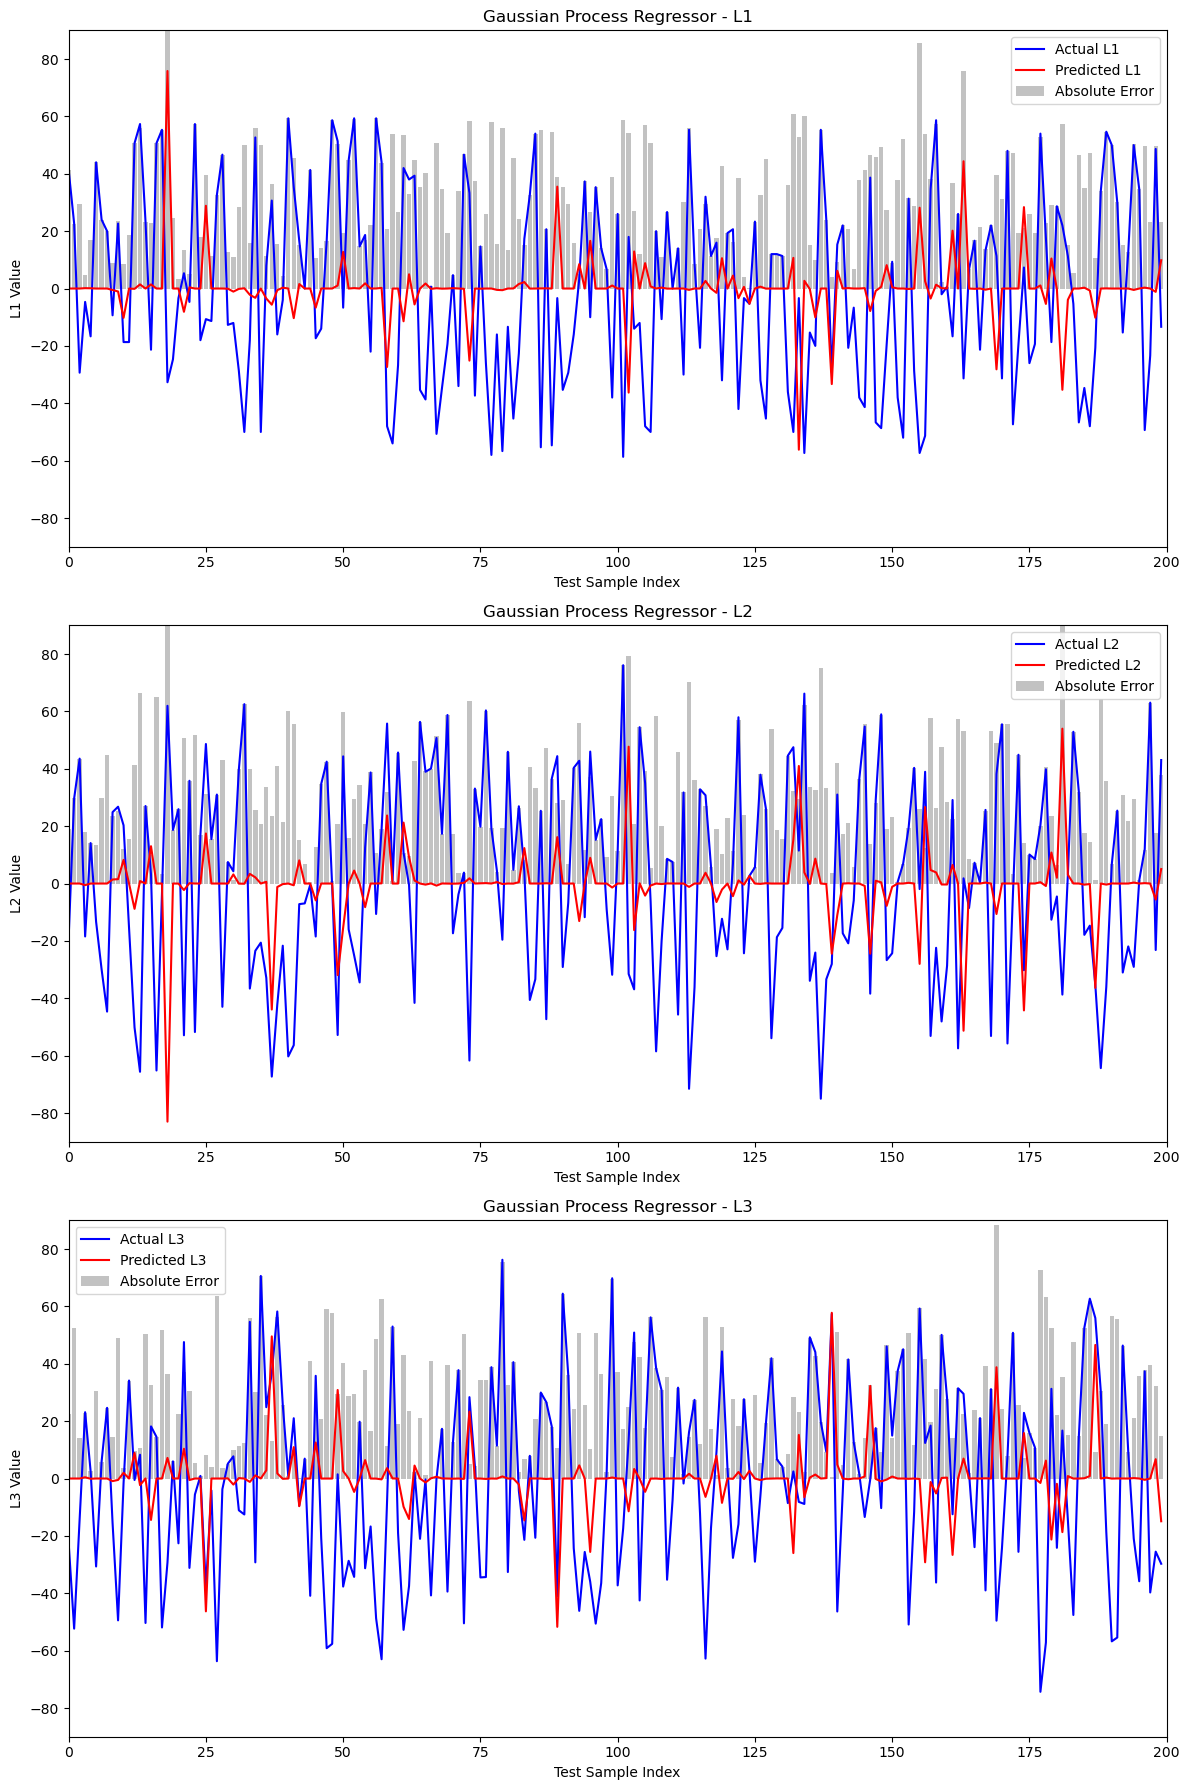

                        Model     Test MSE   Test MAE  Computation Time (s)
0               Random Forest  1058.216120  25.694405              0.699671
1           Gradient Boosting   866.197726  23.549753              0.218444
2            Ridge Regression   927.343365  24.714297              0.005970
3            Lasso Regression   927.339126  24.714440              0.004844
4    Support Vector Regressor   935.759171  24.398921              0.078092
5     Bayesian Neural Network   871.776272  24.010182              8.237875
6    Recurrent Neural Network   874.874127  24.215739              9.808284
7  Gaussian Process Regressor  1243.854615  29.352238              0.276217


In [23]:
for name, model in models.items():
    start_time = time.time()
    
    if name == "Bayesian Neural Network":
        model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0, validation_data=(X_test, y_test))
        y_pred = model.predict(X_test)
    elif name == "Recurrent Neural Network":
        model.fit(X_train_rnn, y_train, epochs=100, batch_size=10, verbose=0, validation_data=(X_test_rnn, y_test))
        y_pred = model.predict(X_test_rnn)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    end_time = time.time()
    computation_time = end_time - start_time
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    results.append({
        "Model": name,
        "Test MSE": mse,
        "Test MAE": mae,
        "Computation Time (s)": computation_time
    })
    
    # Plot comparisons for each output
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 18))
    for i, label in enumerate(['L1', 'L2', 'L3']):
        axes[i].plot(range(len(y_test)), y_test[label], color='blue', label=f'Actual {label}')
        axes[i].plot(range(len(y_pred)), y_pred[:, i], color='red', label=f'Predicted {label}')
        abs_diff = abs(y_test[label] - y_pred[:, i])
        axes[i].bar(range(len(y_test)), abs_diff, color='darkgrey', alpha=0.7, label='Absolute Error')
        axes[i].set_title(f'{name} - {label}')
        axes[i].set_xlabel('Test Sample Index')
        axes[i].set_ylabel(f'{label} Value')
        axes[i].legend()
        axes[i].set_xlim(0, 200)  # Set xlim here
        axes[i].set_ylim(-90, 90)  # Set ylim here
    fig.tight_layout()
    plt.savefig(output + 'fig_' + f"{name.replace(' ', '_')}_results.png", dpi=300)
    plt.show()

# Display the results
results_df = pd.DataFrame(results)
print(results_df)

# Function to construct linear equation
def construct_linear_equation(label, intercept, coefs):
    terms = ['α', 'β']
    equation = f"{label} = {intercept:.4f}"
    for term, coef in zip(terms, coefs):
        equation += f" + ({coef:.4f})*{term}"
    return equation

# Function to construct polynomial equation
def construct_polynomial_equation(label, intercept, coefs, terms):
    equation = f"{label} = {intercept:.4f}"
    for term, coef in zip(terms, coefs):
        equation += f" + ({coef:.4f})*{term}"
    return equation



#### After the training process, let's identify the transfer functions derived from each model using polynomial regression.

## Transfer Function Identifications

In [20]:
# Compute transfer functions for each model
transfer_functions = {}

for name, model in models.items():
    if name not in ["Bayesian Neural Network", "Recurrent Neural Network"]:
        model.fit(X_train, y_train)
        if name in ["Ridge Regression", "Lasso Regression"]:
            intercepts = [estimator.intercept_ for estimator in model.estimators_]
            coefs = [estimator.coef_ for estimator in model.estimators_]
            
            tf = []
            for i, label in enumerate(['L1', 'L2', 'L3']):
                tf.append(construct_linear_equation(label, intercepts[i], coefs[i]))
            transfer_functions[name] = tf
        else:
            poly = PolynomialFeatures(degree=2, include_bias=False)
            X_poly = poly.fit_transform(X_train)
            
            poly_model_L1 = LinearRegression().fit(X_poly, y_train['L1'])
            poly_model_L2 = LinearRegression().fit(X_poly, y_train['L2'])
            poly_model_L3 = LinearRegression().fit(X_poly, y_train['L3'])
            
            coefs_L1 = poly_model_L1.coef_
            coefs_L2 = poly_model_L2.coef_
            coefs_L3 = poly_model_L3.coef_
            intercept_L1 = poly_model_L1.intercept_
            intercept_L2 = poly_model_L2.intercept_
            intercept_L3 = poly_model_L3.intercept_
            
            terms = poly.get_feature_names_out(['α', 'β'])
            
            tf = [
                construct_polynomial_equation('L1', intercept_L1, coefs_L1, terms),
                construct_polynomial_equation('L2', intercept_L2, coefs_L2, terms),
                construct_polynomial_equation('L3', intercept_L3, coefs_L3, terms)
            ]
            transfer_functions[name] = tf

# Display the results
results_df = pd.DataFrame(results)
print(results_df)

# Select the most fit model based on the lowest MSE
best_model_name = results_df.loc[results_df['Test MSE'].idxmin()]['Model']
best_model = models.get(best_model_name)

# Compute transfer functions for the best model
best_model_tf = []
if best_model_name not in ["Bayesian Neural Network", "Recurrent Neural Network"]:
    best_model.fit(X_train, y_train)
    if best_model_name in ["Ridge Regression", "Lasso Regression"]:
        intercepts = [estimator.intercept_ for estimator in best_model.estimators_]
        coefs = [estimator.coef_ for estimator in best_model.estimators_]
        
        for i, label in enumerate(['L1', 'L2', 'L3']):
            best_model_tf.append(construct_linear_equation(label, intercepts[i], coefs[i]))
    else:
        poly = PolynomialFeatures(degree=2, include_bias=False)
        X_poly = poly.fit_transform(X_train)
        
        poly_model_L1 = LinearRegression().fit(X_poly, y_train['L1'])
        poly_model_L2 = LinearRegression().fit(X_poly, y_train['L2'])
        poly_model_L3 = LinearRegression().fit(X_poly, y_train['L3'])
        
        coefs_L1 = poly_model_L1.coef_
        coefs_L2 = poly_model_L2.coef_
        coefs_L3 = poly_model_L3.coef_
        intercept_L1 = poly_model_L1.intercept_
        intercept_L2 = poly_model_L2.intercept_
        intercept_L3 = poly_model_L3.intercept_
        
        terms = poly.get_feature_names_out(['α', 'β'])
        
        best_model_tf = [
            construct_polynomial_equation('L1', intercept_L1, coefs_L1, terms),
            construct_polynomial_equation('L2', intercept_L2, coefs_L2, terms),
            construct_polynomial_equation('L3', intercept_L3, coefs_L3, terms)
        ]


# Add the best model's transfer function to the dictionary
transfer_functions[best_model_name] = best_model_tf

print("Best Model:", best_model_name)
print("\nTransfer Functions for All Models:")
for model_name, functions in transfer_functions.items():
    print(f"\n{model_name}:")
    for func in functions:
        print(func)

                        Model     Test MSE   Test MAE  Computation Time (s)
0               Random Forest  1058.216120  25.694405              0.696347
1           Gradient Boosting   866.197726  23.549753              0.231883
2            Ridge Regression   927.343365  24.714297              0.021434
3            Lasso Regression   927.339126  24.714440              0.017389
4    Support Vector Regressor   935.759171  24.398921              0.087110
5     Bayesian Neural Network   868.649674  24.013656              8.170834
6    Recurrent Neural Network   881.754078  24.185505              9.745340
7  Gaussian Process Regressor  1243.854615  29.352238              0.488571
Best Model: Gradient Boosting

Transfer Functions for All Models:

Random Forest:
L1 = 1.0197 + (0.1833)*α + (-0.0700)*β + (-0.0001)*α^2 + (0.0002)*α β + (-0.0001)*β^2
L2 = -0.4349 + (-0.0089)*α + (0.2548)*β + (0.0002)*α^2 + (-0.0004)*α β + (-0.0003)*β^2
L3 = -0.5848 + (-0.1744)*α + (-0.1848)*β + (-0.0001)*α^2 + (0

#### Let's visualize the optimized transfer functions in 3D and compare it with the original ones.

## Visualization of Transfer Functions

### Optimized transfer functions

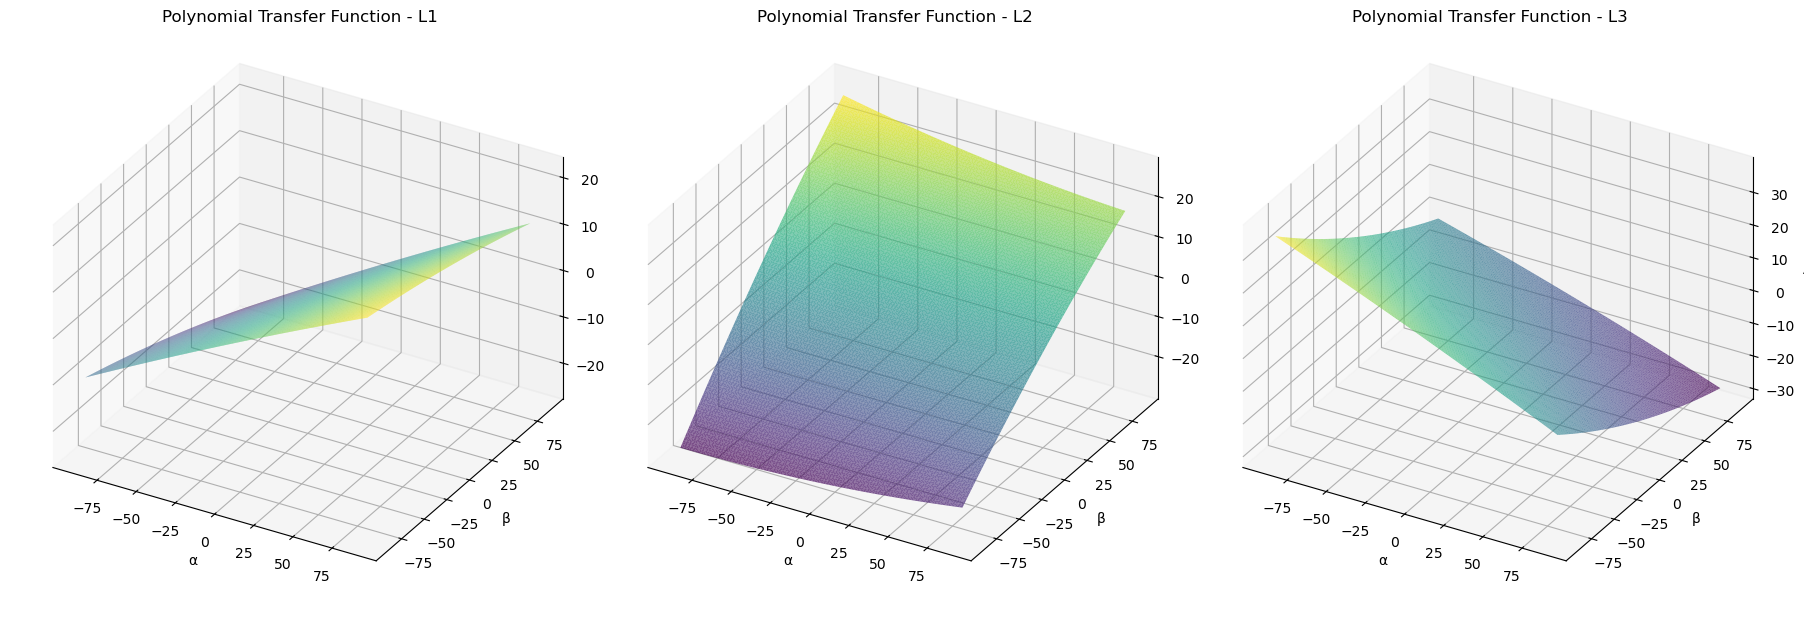

In [25]:
# Plot the polynomial transfer functions as 3D surface plots
fig = plt.figure(figsize=(18,6.5))
for i, (label, model) in enumerate(zip(['L1', 'L2', 'L3'], [poly_model_L1, poly_model_L2, poly_model_L3])):
    ax = fig.add_subplot(1, 3, i+1, projection='3d', proj_type='ortho')

    # Generate a range of input values
    alpha_range = np.linspace(-90, 90, 100)
    beta_range = np.linspace(-90, 90, 100)
    alpha_grid, beta_grid = np.meshgrid(alpha_range, beta_range)
    X_grid = pd.DataFrame(np.c_[alpha_grid.ravel(), beta_grid.ravel()], columns=['α', 'β'])
    X_grid_poly = poly.transform(X_grid)

    # Predict the output values
    y_grid_pred = model.predict(X_grid_poly)

    # Plot the transfer function as a 3D trisurf plot
    ax.plot_trisurf(X_grid['α'], X_grid['β'], y_grid_pred, cmap='viridis', edgecolor='none', alpha=0.7)
    ax.set_title(f'Polynomial Transfer Function - {label}')
    ax.set_xlabel('α')
    ax.set_ylabel('β')
    ax.set_zlabel('ΔL')
    
plt.tight_layout()
# plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, hspace=0.5)
plt.savefig(output + "fig_Polynomial_Transfer_Functions_3D.png", dpi=300)
plt.show()

### Original transfer functions
#### [Reference] Explicit demonstrations can be found in => https://doi.org/10.3390/fractalfract7010008

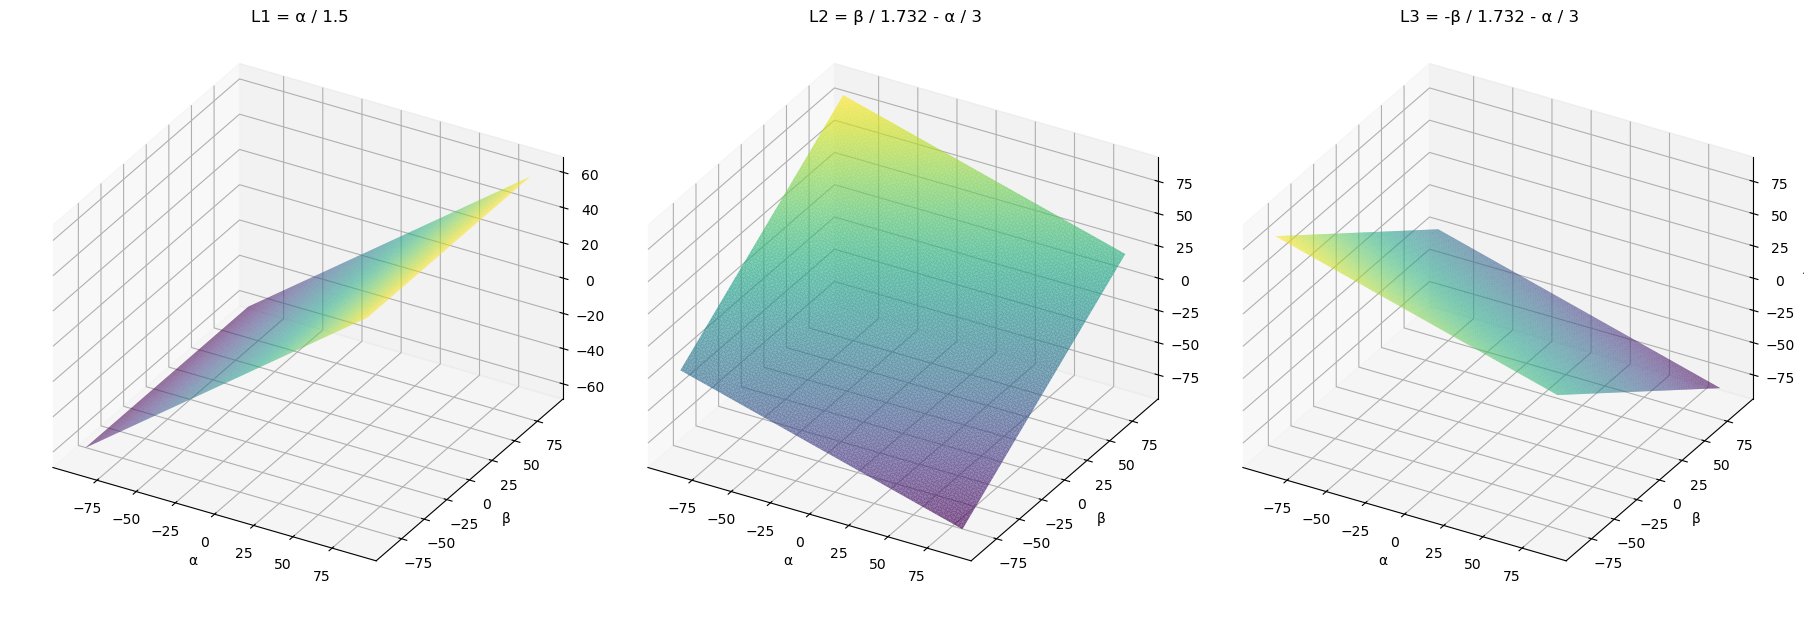

In [26]:
# Define the equations
def L1(alpha):
    return alpha / 1.5

def L2(alpha, beta):
    return beta / 1.732 - alpha / 3

def L3(alpha, beta):
    return -beta / 1.732 - alpha / 3

# Generate a range of input values
alpha_range = np.linspace(-90, 90, 100)
beta_range = np.linspace(-90, 90, 100)
alpha_grid, beta_grid = np.meshgrid(alpha_range, beta_range)
alpha_flat = alpha_grid.ravel()
beta_flat = beta_grid.ravel()

# Calculate the output values
L1_values = L1(alpha_flat)
L2_values = L2(alpha_flat, beta_flat)
L3_values = L3(alpha_flat, beta_flat)

# Plot the transfer functions as 3D trisurf plots
fig = plt.figure(figsize=(18, 6.5))

# Plot L1
ax1 = fig.add_subplot(1, 3, 1, projection='3d', proj_type='ortho')
ax1.plot_trisurf(alpha_flat, beta_flat, L1_values, cmap='viridis', edgecolor='none', alpha=0.7)
ax1.set_title('L1 = α / 1.5')
ax1.set_xlabel('α')
ax1.set_ylabel('β')
ax1.set_zlabel('ΔL')

# Plot L2
ax2 = fig.add_subplot(1, 3, 2, projection='3d', proj_type='ortho')
ax2.plot_trisurf(alpha_flat, beta_flat, L2_values, cmap='viridis', edgecolor='none', alpha=0.7)
ax2.set_title('L2 = β / 1.732 - α / 3')
ax2.set_xlabel('α')
ax2.set_ylabel('β')
ax2.set_zlabel('ΔL')

# Plot L3
ax3 = fig.add_subplot(1, 3, 3, projection='3d', proj_type='ortho')
ax3.plot_trisurf(alpha_flat, beta_flat, L3_values, cmap='viridis', edgecolor='none', alpha=0.7)
ax3.set_title('L3 = -β / 1.732 - α / 3')
ax3.set_xlabel('α')
ax3.set_ylabel('β')
ax3.set_zlabel('ΔL')

plt.tight_layout()
plt.savefig(output + "fig_Original_Transfer_Functions_3D.png", dpi=300)
plt.show()